In [1]:
from matplotlib import pyplot as plt
import os
import torch
%matplotlib inline
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from datasets import load_dataset
from transformers import AutoModelForPreTraining, AutoTokenizer
from sklearn.preprocessing import normalize
import numpy as np
import matplotlib.ticker as ticker
import seaborn as sns
import sys
sys.path.append("/n/fs/nlp-mengzhou/space3/hf")

from transformers import AutoModelForMaskedLM
from templates import *
from utils import *
from models import *
sns.set_style("whitegrid", {'axes.grid' : False})

In [2]:
task = "sst2"
additional_info = {}
names = {"bert-base-uncased": "bert", "roberta-base": "roberta", "google/electra-base-discriminator": "electra"}
for model in ["bert-base-uncased", "roberta-base", "google/electra-base-discriminator"]:
    model_dir = f"/n/fs/nlp-mengzhou/space3/out/hf/analysis_v1/{model}/{task}"
    file = os.path.join(model_dir, "additional-info.pt")
    if os.path.exists(file):
        this_reps = torch.load(file)
        additional_info[f"zeroshot-{names[model]}"] = this_reps
    else:
        print(f"{file} does not exist")


In [3]:
sst2_model_dirs = ["/n/fs/nlp-mengzhou/space3/out/hf/few_shot/sst2/bert-base-uncased/shot16/prompt_FT/1/bs4_lr2e-5",
    "/n/fs/nlp-mengzhou/space3/out/hf/few_shot/sst2/roberta-base/shot16/prompt_FT/1/bs4_lr1e-5",
    "/n/fs/nlp-mengzhou/space3/out/hf/few_shot/sst2/google/electra-base-discriminator/shot16/prompt_FT/1/bs8_lr1e-5",]
boolq_model_dirs = ["/n/fs/nlp-mengzhou/space3/out/hf/few_shot/boolq/bert-base-uncased/shot16/prompt_FT/3/bs2_lr2e-5",
                   "/n/fs/nlp-mengzhou/space3/out/hf/few_shot/boolq/roberta-base/shot16/prompt_FT/3/bs2_lr2e-5",
                   "/n/fs/nlp-mengzhou/space3/out/hf/few_shot/boolq/google/electra-base-discriminator/shot16/prompt_FT/3/bs2_lr2e-5"]
sst5_model_dirs = ["", "", "/n/fs/nlp-mengzhou/space3/out/hf/few_shot/sst5/google/electra-base-discriminator/shot16/prompt_FT/1/bs8_lr2e-5"]
agnews_model_dirs = ["", "", "/n/fs/nlp-mengzhou/space3/out/hf/few_shot/ag_news/google/electra-base-discriminator/shot16/prompt_FT/9/bs8_lr1e-5"]
model_dirs = {"sst2": sst2_model_dirs, "boolq": boolq_model_dirs, "sst5": sst5_model_dirs, "ag_news": agnews_model_dirs}
for model_dir in model_dirs[task]:
    file = os.path.join(model_dir, "additional-info.pt")
    if os.path.exists(file):
        this_reps = torch.load(file)
        if "roberta" in model_dir:
            model = "roberta"
        elif "bert" in model_dir:
            model = "bert"
        elif "electra" in model_dir:
            model = "electra"
        additional_info[f"fewshot-{model}"] = this_reps
    else:
        print(f"{file} does not exist")

In [305]:
label_words = {"sst2": [" terrible", " great"]}
static_reps = {}
def get_static_reps(static_reps, model_name, prefix):
    model = AutoModelForPreTraining.from_pretrained(model_name)
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    if "roberta" in model_name:
        embeddings = model.state_dict()["roberta.embeddings.word_embeddings.weight"]
        static_reps_roberta = []
        for label_word in label_words[task]:
            index = tokenizer.encode(label_word)[1]
            static_reps_roberta.append(embeddings[index])
        static_reps_roberta = torch.stack(static_reps_roberta)
        static_reps[f"{prefix}-roberta"] = static_reps_roberta
    elif "bert" in model_name:
        embeddings = model.state_dict()["bert.embeddings.word_embeddings.weight"]
        static_reps_bert = []
        for label_word in label_words[task]:
            index = tokenizer.encode(label_word.strip())[1]
            static_reps_bert.append(embeddings[index])
        static_reps_bert = torch.stack(static_reps_bert)
        static_reps[f"{prefix}-bert"] = static_reps_bert
    else:
        embeddings = model.state_dict()["electra.embeddings.word_embeddings.weight"]
        weight_params = model.state_dict()["discriminator_predictions.dense_prediction.weight"]
        bias_params = model.state_dict()["discriminator_predictions.dense_prediction.bias"]
        static_reps[f"{prefix}-electra"] = [weight_params, bias_params]

static_reps = {}
for model_name in names:
    get_static_reps(static_reps, model_name, "zeroshot")
for model_dir in model_dirs:
    get_static_reps(static_reps, model_dir, "fewshot")
    

Some weights of BertForPreTraining were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['cls.predictions.decoder.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


KeyboardInterrupt: 

In [76]:
def pca(reps):
    pca_model = PCA(n_components=2).fit(reps)
    return pca_model

def pca_infer(pca_model, reps):
    return pca_model.transform(reps)

In [77]:
def get_data_type(task):
    if task in ["sst2", "qnli", "rte", "mnli"]:
        return "glue"
    elif task in ["sst5", "mr"]:
        return "file"
    else:
        return "other"

In [35]:
def get_dataset(task):
    data_type = get_data_type(task)
    if data_type == "glue":
        dataset = load_dataset("glue", task)["validation"]
    elif data_type == "other":
        dataset = load_dataset(task)
        if task == "imdb":
            dataset = dataset["test"]
        else:
            dataset = dataset["validation"]
        if task == "boolq":
            dataset = dataset.add_column("label", dataset["answer"])
    else:
        dataset = None
    return dataset

In [109]:
def extended(ax, x, y, **args):

    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    x_ext = np.linspace(xlim[0], xlim[1], 100)
    p = np.polyfit(x, y , deg=1)
    y_ext = np.poly1d(p)(x_ext)
    ax.plot(x_ext, y_ext, **args)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    return ax

In [303]:
from sklearn.linear_model import LogisticRegression
dataset = get_dataset(task)
def prob(reps, labels):
    if len(reps) > len(labels):
        reps = reps.reshape(-1, 2, reps.shape[-1])
        reps = reps[:, 1] - reps[:, 0]
    clf = LogisticRegression(random_state=0).fit(reps, labels)
    preds = clf.predict(reps)
    return (preds == labels).sum() / len(preds)
for model in ["bert", "roberta", "electra"]:
    print(reps[f"zeroshot-{model}"].shape)
    print(prob(reps[f"zeroshot-{model}"], dataset["label"]))

Using custom data configuration default
Reusing dataset boolq (/n/fs/nlp-mengzhou/.cache/datasets/boolq/default/0.1.0/bf0dd57da941c50de94ae3ce3cef7fea48c08f337a4b7aac484e9dddc5aa24e5)


  0%|          | 0/2 [00:00<?, ?it/s]

(3270, 768)
0.7076452599388379
(3270, 768)


/n/fs/nlp-mengzhou/anaconda3/envs/updated/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/n/fs/nlp-mengzhou/anaconda3/envs/updated/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

0.7006116207951071
(6540, 768)
0.6957186544342507


/n/fs/nlp-mengzhou/anaconda3/envs/updated/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


/tmp/ipykernel_7726/2483707788.py:36: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  ax.scatter(pca_reps[index, 0], pca_reps[index, 1], label=f"{features[label]}", c="plum" if label == 0 else "steelblue")
/tmp/ipykernel_7726/2483707788.py:36: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  ax.scatter(pca_reps[index, 0], pca_reps[index, 1], label=f"{features[label]}", c="plum" if label == 0 else "steelblue")
/tmp/ipykernel_7726/2483707788.py:36: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  ax.scatter(pca_reps[index, 0], pca_reps[index, 1], label=f"{features[label]}", c="plum" if label == 0 else "steelblue")


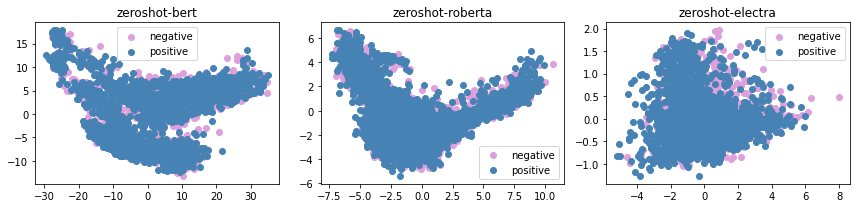

In [304]:
def get_decision_boundary(reps_model, static_reps):
    def get_boundary_point(index):
        last_ele = (0 - np.dot(reps_model[index][:-1], static_reps[:-1])) / static_reps[-1]
        boundary_point = np.concatenate([reps_model[index][:-1].tolist(), [last_ele]])
        return boundary_point
    p1 = get_boundary_point(0)
    p2 = get_boundary_point(3)
    all_points = []
    for i in range(100):
        all_points.append(get_boundary_point(i))
    return p1, p2, all_points
    

def transform_point(p1, pca_model):
    p1 = pca_model.transform(p1)
    return p1


prefix = "zeroshot"
num_labels = 2
labels = np.array(dataset["label"])
features = sst2_dataset.features["label"].names
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
for i, model_name in enumerate(["bert", "roberta", "electra"]):
    ax = axes[i]
    model_name = f"{prefix}-{model_name}"
    reps_model = reps[model_name]
    if "electra" in model_name:
        reps_model = reps_model.reshape(-1, num_labels, reps_model.shape[-1])
        reps_model = reps_model[:, 0] - reps_model[:, 1]
#     reps_model = normalize(reps_model)
    pca_model = pca(reps_model)
    pca_reps = pca_infer(pca_model, reps_model)
    for label in set(labels):
        index = np.where(labels == label)[0]
        ax.scatter(pca_reps[index, 0], pca_reps[index, 1], label=f"{features[label]}", c="plum" if label == 0 else "steelblue")
        ax.legend()
        ax.set_title(model_name)
fig.tight_layout()
plt.savefig(f"images/zeroshot-{task}.pdf")


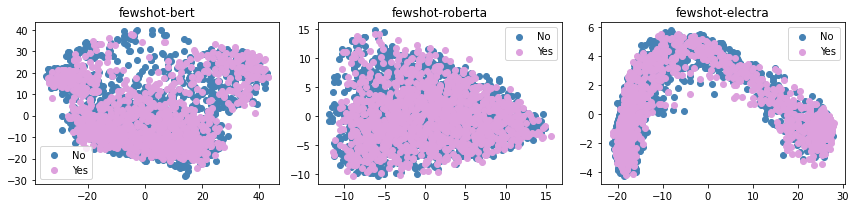

In [312]:

prefix = "fewshot"
num_labels = 2
labels = np.array(dataset["label"])
features = ["Yes", "No"]
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
for i, model_name in enumerate(["bert", "roberta", "electra"]):
    ax = axes[i]
    model_name = f"{prefix}-{model_name}"
    reps_model = reps[model_name]
#     reps_model = normalize(reps_model)
    if "electra" in model_name:
        reps_model = reps_model.reshape(-1, num_labels, reps_model.shape[-1])
        reps_model = reps_model[:, 0] - reps_model[:, 1]
    pca_model = pca(reps_model)
    pca_reps = pca_infer(pca_model, reps_model)
    for label in [1, 0]:
        index = np.where(labels == label)[0]
        ax.scatter(pca_reps[index, 0], pca_reps[index, 1], label=f"{features[label]}", c="plum" if label == 0 else "steelblue")
        ax.legend()
        ax.set_title(model_name)
fig.tight_layout()
plt.savefig(f"images/16shot-{task}.pdf")

In [3]:
# prediction distribution

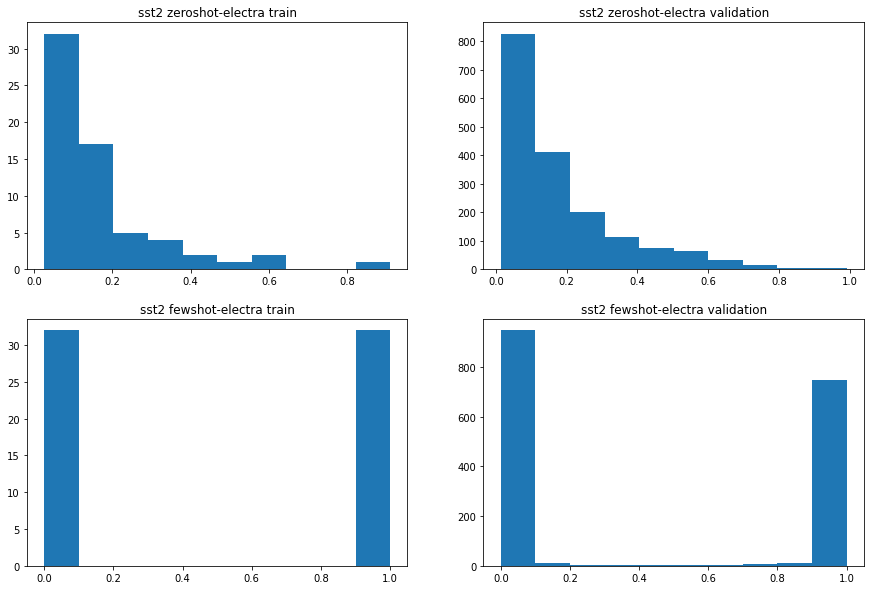

In [4]:

def sigmoid(z):
    return 1/(1 + np.exp(-z))

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
for i, tt in enumerate(additional_info):
    for j, subset in enumerate(["train", "fewshot_validation"]):
        logits = additional_info[tt][subset]["logits"]
        axes[i][j].hist(sigmoid(logits))
        axes[i][j].set_title(f"{task} {tt} {subset if subset == 'train' else 'validation'}")

## Preprocess function for text

In [ ]:

max_seq_length = 512
objective = "mlm"
padding="max_length"
num_labels = 2

def preprocess_function(examples, template=None, label_name="label"):
    result = tokenize_and_mapping(examples, template, tokenizer, 512, "mlm", "prompt", None, padding, num_labels)
    return result

processed_dataset = encoded_dataset.map(lambda x: preprocess_function(x), batched=True)

## Plot function

In [195]:
def plot_one(ax, logits):
    sns.histplot(data=logits,  ax=ax, binwidth=0.1, )
    lens = len(logits)
    ax.yaxis.set_major_formatter(ticker.PercentFormatter(len(logits))) # xmax=len(logits_k_h)))
    ax.set_xticks([0, 1])
    ax.tick_params(axis='y', labelsize=15)
    ax.tick_params(axis='x', labelsize=15)
    ax.set_xlabel("")
    ax.set_ylabel("")
    
def plot_four(objective, axes, logits, labels):
    for k in range(num_labels):
        for h in range(num_labels):
            index = np.where(labels == k)[0]
            if objective == "dis":
                logits_k_h = 1 - sigmoid(logits[index, h])
            else:
                logits_k_h = softmax(logits)[index, h]
            plot_one(ax=axes[k][h], logits=logits_k_h)
            if h == 0:
                axes[k][h].set_ylabel(y_words[k], fontsize=17)
            if k == num_labels - 1 :
                axes[k][h].set_xlabel(label_words[h], fontsize=17)
           
print(labels.shape)
print(logits.shape)

(9842,)
(9842, 3)


## keyword output distribution analysis

In [130]:
model = AutoModelForMaskedLM.from_pretrained("google/electra-base-generator")
tokenizer = AutoTokenizer.from_pretrained("google/electra-base-generator")

In [13]:
def get_keyword_id(keyword):
    return tokenizer(keyword)["input_ids"][1]

In [96]:
# load_data from great terrible
file = "/n/fs/nlp-mengzhou/space3/meta/data/sample_roberta/terrible.sents"
lines = open(file, "r").readlines()
inputs = tokenizer(lines, truncation=True)
great_id = get_keyword_id("great")
terrible_id = get_keyword_id("terrible")
m = nn.Softmax(dim=-1)

great_logits = []
terrible_logits = []
great_probs = []
terrible_probs = []
for i in range(len(inputs["input_ids"])):
    input_ids = torch.tensor(inputs["input_ids"][i])
    keyword_index = torch.where(input_ids == terrible_id)[0]
    if len(keyword_index) == 1:
        keyword_index == keyword_index[0]
    input_ids[keyword_index] = tokenizer.mask_token_id
    input_ids = input_ids.unsqueeze(0)
    attention_mask = torch.tensor(inputs["attention_mask"][i]).unsqueeze(0)
    logits = model(input_ids, attention_mask).logits
    probs = m(logits)
    great_logit = logits[0, keyword_index, great_id]
    terrible_logit = logits[0, keyword_index, terrible_id]
    great_prob = probs[0, keyword_index, great_id]
    terrible_prob = probs[0, keyword_index, terrible_id]
    
    great_logits.append(great_logit)
    terrible_logits.append(terrible_logit)
    great_probs.append(great_prob)
    terrible_probs.append(terrible_prob)
    
    if (i+1) % 100 == 0:
        print(f"{i+1} examples are done.")

100 examples are done.
200 examples are done.
300 examples are done.
400 examples are done.
500 examples are done.
600 examples are done.
700 examples are done.
800 examples are done.
900 examples are done.
1000 examples are done.


In [91]:
from copy import deepcopy

great_great_logits = torch.cat(great_logits).clone()
great_terrible_logits = torch.cat(terrible_logits).clone()
great_great_probs = torch.cat(great_probs).clone()
great_terrible_probs = torch.cat(terrible_probs).clone()

In [97]:
terrible_great_logits = torch.cat(great_logits).clone()
terrible_terrible_logits = torch.cat(terrible_logits).clone()
terrible_great_probs = torch.cat(great_probs).clone()
terrible_terrible_probs = torch.cat(terrible_probs).clone()

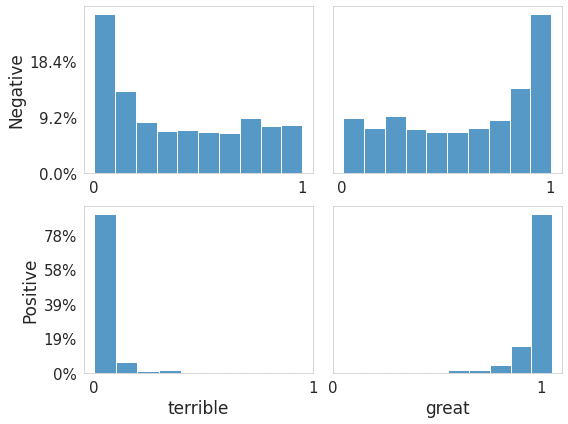

In [129]:
num_labels = 2
label_words = ["terrible", "great"]
fig, axes = plt.subplots(2, 2, figsize=(8, 6))
great_logits = torch.cat([great_terrible_logits.unsqueeze(-1), great_great_logits.unsqueeze(-1)], dim=1)
terrible_logits = torch.cat([terrible_terrible_logits.unsqueeze(-1), terrible_great_logits.unsqueeze(-1)], dim=1)
logits = torch.cat([terrible_logits, great_logits, ], dim=0).detach().numpy()
plot_four("mlm", axes, logits, torch.tensor([0] * len(great_great_logits) + [1] * len(terrible_great_logits)))
fig.tight_layout()
plt.savefig("images/sample_sentences_dist.pdf")

## Plot the zero-shot and few-shot predictions 

In [185]:
# load the zero-shot predictions

task = "snli"
num_labels = 2
additional_info = {}
names = {"bert-base-uncased": "bert", 
         "roberta-base": "roberta", 
         "google/electra-base-discriminator": "electra",
         "google/electra-base-generator": "electra_generator"}

for model in ["bert-base-uncased", "roberta-base", "google/electra-base-discriminator", "google/electra-base-generator"]:
    model_dir = f"/n/fs/nlp-mengzhou/space3/out/hf/analysis_v1/{model}/{task}"
    file = os.path.join(model_dir, "additional-info.pt")
    if os.path.exists(file):
        this_reps = torch.load(file)
        additional_info[f"zeroshot-{names[model]}"] = this_reps
    else:
        print(f"{file} does not exist")


/n/fs/nlp-mengzhou/space3/out/hf/analysis_v1/bert-base-uncased/snli/additional-info.pt does not exist
/n/fs/nlp-mengzhou/space3/out/hf/analysis_v1/google/electra-base-generator/snli/additional-info.pt does not exist


In [190]:
additional_info["zeroshot-roberta"][""]

{'fewshot_validation': defaultdict(list,
             {'logits': array([17.954926, 12.519672, 15.957389, ..., 13.217457,  9.160052,
                     11.806158], dtype=float32),
              'labels': array([1, 0, 2, ..., 0, 2, 1])})}

In [187]:
dataset = load_dataset("snli")
labels = np.array(dataset["validation"]["label"])

Reusing dataset snli (/n/fs/nlp-mengzhou/.cache/datasets/snli/plain_text/1.0.0/1f60b67533b65ae0275561ff7828aad5ee4282d0e6f844fd148d05d3c6ea251b)


  0%|          | 0/3 [00:00<?, ?it/s]

ACC for LABEL 0: 99.8
ACC for LABEL 1: 0.1


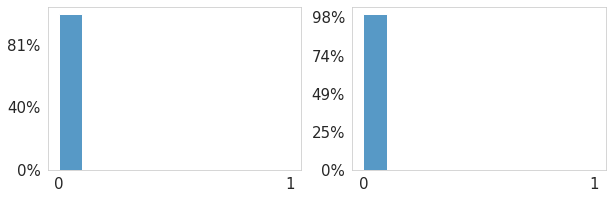

In [137]:
key = "zeroshot-electra_generator"
ori_logits = additional_info[key]["fewshot_validation"]["logits"].reshape(-1, num_labels)
fig, axes = plt.subplots(1, 2, figsize=(10, 3))

num_labels = 2
for label in range(num_labels):
    class_logits = ori_logits[labels == label]
    if key == "zeroshot-electra":
        pred = class_logits.argmin(-1)
    else:
        pred = class_logits.argmax(-1)
    
    plot_one(axes[label], pred.astype(float))
    print(f"ACC for LABEL {label}: {round((pred == label).sum() / len(pred) * 100, 1)}")
    

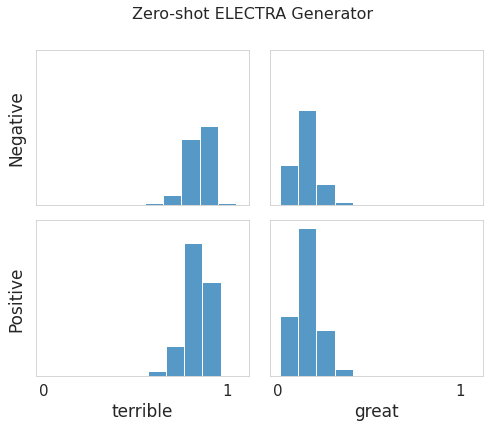

In [138]:
fig, axes = plt.subplots(num_labels, num_labels, figsize=(8, 6), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.1, wspace=0.1)
for i, tt in enumerate(["zeroshot-electra_generator"]):
    objective = map_to_objective(tt)
    for j, subset in enumerate(["fewshot_validation"]):
        logits = additional_info[tt][subset]["logits"].reshape(-1, num_labels)
#         if objective == "dis":
#             labels_labels = labels.reshape(-1, num_labels)
#             labels = labels.argmin(-1)
        plot_four(objective, axes[:, i*num_labels: (i+1)*num_labels], logits, labels)
fig.suptitle('Zero-shot ELECTRA Generator', fontsize=16)
plt.savefig(f"images/{task}-zeroshot-electra_generator.pdf")

In [141]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))
def softmax(z, temp=1):
    return ((np.exp(z)**temp) / (np.exp(z).sum(-1).reshape(-1, 1)**temp))
def map_to_objective(key):
    model = key.split("-")[1]
    if model == "electra":
        return "dis"
    return "mlm"
z = additional_info["zeroshot-roberta"]["fewshot_validation"]["logits"].reshape(-1, num_labels)
additional_info.keys()

dict_keys(['zeroshot-roberta', 'zeroshot-electra', 'zeroshot-electra_generator'])

In [164]:
additional_info["zeroshot-electra"]["fewshot_validation"]["logits"].reshape(-1, 3).shape

(9842, 3)

Text(0.5, 0.98, 'Zero-Shot RoBERTa                               Zero-Shot ELECTRA')

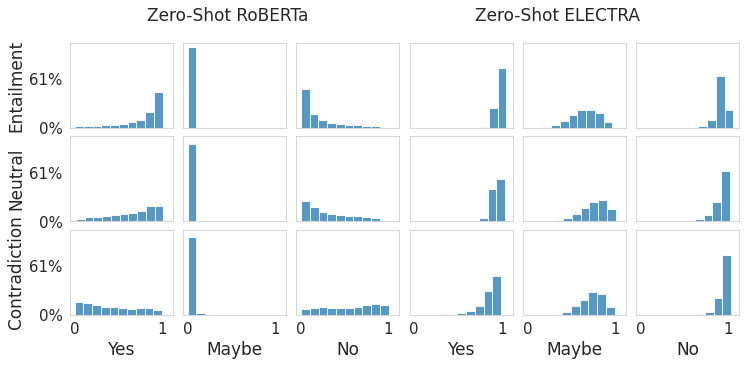

In [203]:
colors = sns.color_palette(as_cmap=True)
num_labels = 3
y_words = ["Entailment", "Neutral", "Contradiction"]
label_words = ["Yes", "Maybe", "No"]
fig, axes = plt.subplots(num_labels, num_labels*2, figsize=(12, 5), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.1, wspace=0.1)
labels = additional_info["zeroshot-roberta"][subset]["labels"]
for i, tt in enumerate(["zeroshot-roberta", "zeroshot-electra"]):
    objective = map_to_objective(tt)
    for j, subset in enumerate(["fewshot_validation"]):
        logits = additional_info[tt][subset]["logits"].reshape(-1, num_labels)
        logits = logits.reshape(-1, num_labels)
        plot_four(objective, axes[:, i*num_labels: (i+1)*num_labels], logits, labels)
        

if tt == "fewshot-electra":
    fig.suptitle("Few-Shot ELECTRA", fontsize=17)
elif tt == "fewshot-roberta":
    fig.suptitle("Few-Shot RoBERTa", fontsize=17)
elif tt == "zeroshot-electra":
    fig.suptitle("Zero-Shot ELECTRA", fontsize=17)
elif tt == "zeroshot-roberta":
    fig.suptitle("Zero-Shot RoBERTa", fontsize=17)
fig.suptitle("Zero-Shot RoBERTa                               Zero-Shot ELECTRA", fontsize=17)
# plt.savefig(f"images/{task}-zero.pdf", bbox_inches='tight')

In [182]:
additional_info["zeroshot-roberta"]

{'fewshot_validation': defaultdict(list,
             {'logits': array([17.954926, 12.519672, 15.957389, ..., 13.217457,  9.160052,
                     11.806158], dtype=float32),
              'labels': []})}

In [18]:
# load few_shot results

sst2_model_dirs = ["/n/fs/nlp-mengzhou/space3/out/hf/few_shot/sst2/bert-base-uncased/shot16/prompt_FT/1/bs4_lr2e-5",
    "/n/fs/nlp-mengzhou/space3/out/hf/few_shot/sst2/roberta-base/shot16/prompt_FT/1/bs4_lr1e-5",
    "/n/fs/nlp-mengzhou/space3/out/hf/few_shot/sst2/google/electra-base-discriminator/shot16/prompt_FT/1/bs8_lr1e-5",]
boolq_model_dirs = ["/n/fs/nlp-mengzhou/space3/out/hf/few_shot/boolq/bert-base-uncased/shot16/prompt_FT/3/bs2_lr2e-5",
                   "/n/fs/nlp-mengzhou/space3/out/hf/few_shot/boolq/roberta-base/shot16/prompt_FT/3/bs2_lr2e-5",
                   "/n/fs/nlp-mengzhou/space3/out/hf/few_shot/boolq/google/electra-base-discriminator/shot16/prompt_FT/3/bs2_lr2e-5"]
sst5_model_dirs = ["", "", "/n/fs/nlp-mengzhou/space3/out/hf/few_shot/sst5/google/electra-base-discriminator/shot16/prompt_FT/1/bs8_lr2e-5"]
agnews_model_dirs = ["", "", "/n/fs/nlp-mengzhou/space3/out/hf/few_shot/ag_news/google/electra-base-discriminator/shot16/prompt_FT/9/bs8_lr1e-5"]
model_dirs = {"sst2": sst2_model_dirs, "boolq": boolq_model_dirs, "sst5": sst5_model_dirs, "ag_news": agnews_model_dirs}
for model_dir in model_dirs[task]:
    file = os.path.join(model_dir, "additional-info.pt")
    if os.path.exists(file):
        this_reps = torch.load(file)
        if "roberta" in model_dir:
            model = "roberta"
        elif "bert" in model_dir:
            model = "bert"
        elif "electra" in model_dir:
            model = "electra"
        additional_info[f"fewshot-{model}"] = this_reps
    else:
        print(f"{file} does not exist")

dict_keys(['zeroshot-electra'])